## Use this to see a mosaic of a single volunteers bounding boxes

In [1]:
import os
import numpy as np
import matplotlib as plt
#import pandas as pd 
#import seaborn as sns
#from PIL import Image
import random
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patch
from skimage.transform import resize

C:\Users\rb01243\AppData\Local\Temp/ipykernel_25088/3919007481.py:58: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if volName in names:


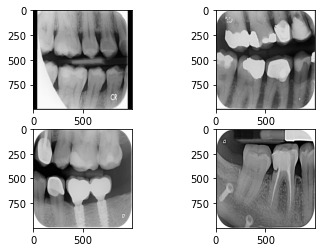

In [12]:
# directory to the images
imgDirec = '../../data/datasets/bcc-tv/images/train'
# directory to the yolo format labels
lblDirec = '../../data/datasets/bcc-tv/labels/train'
# Voulunteer Directory (only for CS datasets)
volDirec = '../../data/datasets/bcc-tv/volunteers/train'
# the location you want to save the images too
saveDirec = 'results'
# the file name of the image to be saved
saveName = 'bcc_tv_all_vol_per_image' # WARNING: YOU HAVE TO USE '_' TO SPLIT UP WORDS
# displays all bounidng boxes for every volunteer for each image. (only works with CS dataset type)
allOrNothing = False   # True = displays all volunteers,   False = only displays the volName volunteer's bounding boxes
# Name of the volunteer you want to view
volName = 'Camellia'
# IID or Crowdsourced Dataset
dsType = 'CS' # IID or CS
# numebr of imges to view
imgNum = 4 # HAS TO BE  EITHER 1, 2, 4, 6, 9, OR 12
# resize the images to a desired pixel value
imgSize = 600
# colour of the bounding box
boxColour = ['r', 'b'] #
# bounding box thickness
boxThickness = 1.0
# class text thickness
textThickness = 1
# the font size of the text
textSize = 5
# the names and order of the classes
clssNames = ['Bone Loss', 'Dental Caries']
# toggle wether you want the class names to appear (True) or class number to appear (False), on the bounding box
toggleClssNames = False


#creates a folder to save the results in
try:
    os.mkdir(saveDirec)
except:
    pass

# Traverses files and finds the wanted image names
saveImgNme = []
if dsType == 'IID':
    for root, dirs, files in os.walk(imgDirec):
        for fleNme in files:
            fleNmeSplit = fleNme.split('.')
            if fleNmeSplit[1] == volName:
                saveImgNme.append(fleNme)
                
elif dsType == 'CS' or allOrNothing == True:
    bBoxPosit = []
    for root, dirs, files in os.walk(volDirec):
        for fleNme in files:
            temp = open(volDirec+'/'+fleNme, "r")
            tempImg = temp.read()
            names = np.array(tempImg.split())
            
            if volName in names:
                saveImgNme.append(fleNme)
                bBoxPosit.append(np.where(names == volName)[0])


                
# Select images
selection = []
selectBoxPosit = []
for rand in range(imgNum):
    randSelect = random.randint(0, len(saveImgNme)-1)
    missingFileHandler = os.path.exists(lblDirec+'/'+saveImgNme[randSelect].replace('.jpg', '.txt'))
    while missingFileHandler == False:
        randSelect = random.randint(0, len(saveImgNme)-1)
        missingFileHandler = os.path.exists(lblDirec+'/'+saveImgNme[randSelect].replace('.jpg', '.txt'))
    selection.append(saveImgNme[randSelect])
    saveImgNme.pop(randSelect)
    if dsType == 'CS':
        selectBoxPosit.append(bBoxPosit[randSelect])
        bBoxPosit.pop(randSelect)

        
# removes unwanted volunteer bounding boxes for the CS dataset type, and prepares the bounding boxes
allLabels = []
if dsType == 'CS':
    for index in range(len(selection)):
        newLabels = []
        lbl = open(lblDirec+'/'+selection[index], "r")
        lbl = lbl.read()
        lbl = lbl.split('\n')
        lbl.pop(-1)
        if allOrNothing == False:
            for remove in selectBoxPosit[index]:
                newLabels.append(lbl[remove])
            allLabels.append(newLabels)
        else:
            allLabels.append(lbl)
# prepares the bounding boxes for the IID dataset
elif dsType == 'IID':
    for index in selection:
        index = index.replace('.jpg', '.txt')
        lbl = open(lblDirec+'/'+index, "r")
        lbl = lbl.read()
        lbl = lbl.split('\n')
        lbl.pop(-1)
        allLabels.append(lbl)


            
fig = plt.figure()
# combines and plots images
flip = True
save = []
count = 0
for images in range(len(selection)):
    curSelect = selection[images].replace('.txt', '.jpg')
    imgs = plt.imread(imgDirec+'/'+curSelect)
    imgs = resize(imgs, (imgSize, imgSize))
    fig.add_subplot(2, 2, images+1)
    #imgs = imgs.resize((imgSize, imgSize))
    #imgs = cv2.resize(imgs, (imgSize, imgSize))
    for bBox in allLabels[images]:
        bBoxVal = bBox.split()
        clss = bBoxVal[0]
        x, y = (float(bBoxVal[1])*imgSize)-((float(bBoxVal[3])*imgSize)/2), (float(bBoxVal[2])*imgSize)-((float(bBoxVal[4])*imgSize)/2)
        w, h = float(bBoxVal[3])*imgSize, float(bBoxVal[4])*imgSize
        if toggleClssNames == True:
            clssVal = clssNames[int(clss)]
        else:
            clssVal = clss
        boxColourNew = boxColour[int(clss)]
        rect = patch.Rectangle((x, y), w, h, linewidth=boxThickness, edgecolor=boxColourNew, facecolor='none')
        ax.add_patch(rect)
        #imgs = cv2.rectangle(imgs, (int(x), int(y)), (int(x+w), int(y+h)), boxColourNew, boxThickness)
        #imgs = matplotlib.patches.Rectangle(imgs, clssVal, (int(x), int(y-5)), linewidth=textThickness,        cv2.FONT_HERSHEY_PLAIN, textSize/5, boxColourNew, textThickness, cv2.LINE_AA)
        ax.annotate(clssVal, (x+w, y-textSize), backgroundcolor=boxColourNew, color='w', weight='bold', fontsize=textSize)
        #if allOrNothing == True and dsType == 'CS':
            #textSize, _ = cv2.getTextSize(clssVal, fontHeight, textThickness, )
            #imgs = cv2.rectangle(imgs, (int(x), int(y)), (int(x+1), int(y+1)), boxColourNew, -1)
            #imgs = cv2.putText(imgs, clssVal, (int(x), int(y-5)), cv2.FONT_HERSHEY_PLAIN, textSize/5, boxColourNew, textThickness, cv2.LINE_AA)
        #else:
            #imgs = cv2.rectangle(imgs, (int(x), int(y-5)), (int(x+1), int(y=1)), boxColourNew, -1)
            #imgs = cv2.putText(imgs, clssVal, (int(x), int(y-5)), cv2.FONT_HERSHEY_PLAIN, textSize/5, boxColourNew, textThickness, cv2.LINE_AA)
    plt.imshow(imgs)
    
    
    # if flip == True:
    #     save.append(imgs)
    #     flip = False
    # else:
    #     save[-1] = np.concatenate((save[-1], imgs), axis=1)
    #     if imgNum < 5:
    #         flip = True
    #     elif 5 < imgNum < 10:
    #         if count == 1:
    #             flip = True
    #             count = 0
    #         else:
    #             count += 1
    #     elif imgNum > 10:
    #         if count == 2:
    #             flip = True
    #             count = 0
    #         else:
    #             count += 1

# if imgNum > 3:
#     for combine in range(len(save)-1):
#         save[combine+1] = np.concatenate((save[combine], save[combine+1]), axis=0)
#     saveFinal = save[-1]
# else:
#     saveFinal = save[0]

# if os.path.exists(saveDirec+'/'+saveName+'.jpg'): 
#     if os.path.exists(saveDirec+'/'+saveName+'_1'+'.jpg'):
#         saveName = saveName + '_1'
#         while os.path.exists(saveDirec+'/'+saveName+'.jpg'):
#             saveName = saveName.split('_')
#             num = int(saveName[-1]) + 1
#             saveName[-1] = str(num)
#             saveName = '_'.join(saveName)
#             if os.path.exists(saveDirec+'/'+saveName+'.jpg') == False:
#                 cv2.imwrite(saveDirec+'/'+saveName+'.jpg', saveFinal)
#                 break
                
#     else:
#         cv2.imwrite(saveDirec+'/'+saveName+'_1'+'.jpg', saveFinal)
# else:
#     cv2.imwrite(saveDirec+'/'+saveName+'.jpg', saveFinal)

# cv2.imshow(saveName,saveFinal)
# cv2.waitKey(0)

    
